### Test only simulated data for case-control data

In [1]:
data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data

N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)
#data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF,
                         data$dn.mis3, data$case.mis3+data$trans.mis3,
                         data$ctrl.mis3+data$ntrans.mis3))
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]


In [2]:
# Generate simulation data of a set of genes (multiple mutational categories): de novo mutations only
# N: sample size (number of trios)
# mu: mutation rate of each gene (a vector)
# mu.frac: for each type of mutation, its fraction of the gene's mutation rate
# pi: the fraction of risk genes 
# gamma.mean, beta: Relative risk of de novo mutation: gamma|M1 ~ Gamma(gamma.mean*beta, beta). Vectors (one per category) 
# Output: sample matrix (m by K), where m is the number of genes and K the number of variant categories. sample.info: more information of the samples, including the indicator (risk gene or not) and the RR. 

simulator.denovo <- function(N, mu, mu.frac, pi, gamma.mean, beta) {
  m <- length(mu) # number of genes
  K <- length(mu.frac) # number of mutational categories
  
  z <- rbinom(m, 1, pi)
  gamma <- array(1, dim=c(m,K))
  x <- array(0, dim=c(m,K))
  k <- sum(z==1)
  for (j in 1:K) {
    gamma[z==1, j] <- rgamma(k, gamma.mean[j]*beta[j], beta[j])
    x[,j] <- rpois(m, 2 * mu * mu.frac[j] * gamma[,j] * N)
  }
  
  sample.info <- cbind(mu, z, gamma, x)
  
  return (list(sample=x, sample.info=sample.info))
}

# Generate simulation data of a set of genes (multiple mutational categories)
# N: sample size (number of trios)
# mu: mutation rate of each gene (a vector)
# mu.frac: for each type of mutation, its fraction of the gene's mutation rate
# pi: the fraction of risk genes 
# gamma.mean.dn, beta.dn: Relative risk of de novo mutation: gamma|M1 ~ Gamma(gamma.mean.dn*beta.dn, beta.dn). Vectors.
# gamma.mean.CC, beta.CC: Relative risk of inherited mutation (case/control): gamma.CC|M1 ~ Gamma(gamma.mean.CC*beta.CC, beta.CC). Vectors
# Frequency parameter of risk genes: q|M1 ~ Gamma(rho1, nu1)
# Frequency parameter of non-risk genes: q|M0 ~ Gamma(rho0, nu0)
# tradeoff option: if TRUE, implement q-gamma tradeoff (i.e. higher gamma means lower q). Suppose, gamma_i is the RR, then q_i is proportional to mu_i / gamma_i, where the constant is determined from the mean of q, mu and gamma. 
# Output: sample matrix (m by 3K), where m is the number of genes and K the number of variant categories.  sample.info: more information of the samples, including the indicator (risk gene or not) and the RR.
simulator <- function(N, mu, mu.frac, pi, gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0, tradeoff=FALSE) {
  m <- length(mu) # number of genes
  K <- length(mu.frac) # number of mutational categories
  
  # the tradeoff parameter (delta:=mu.mean/q.mean)
  delta <- mean(mu) * mu.frac / (rho0 / nu0)
  
  z <- rbinom(m, 1, pi)
  gamma.dn <- array(1, dim=c(m,K))
  gamma.CC <- array(1, dim=c(m,K))
  q <- array(0, dim=c(m,K))
  x <- array(0, dim=c(m,3*K))
  k <- sum(z==1)
  for (j in 1:K) {
    # sample de novo 
    gamma.dn[z==1, j] <- rgamma(k, gamma.mean.dn[j]*beta.dn[j], beta.dn[j])
    col <- 3*(j-1)+1
    x[,col] <- rpois(m, 2 * mu * mu.frac[j] * gamma.dn[,j] * N$dn)
    
    # sample case-control
    gamma.CC[z==1, j] <- rgamma(k, gamma.mean.CC[j]*beta.CC[j], beta.CC[j])
    q[z==0, j] <- rgamma(m-k, rho0[j], nu0[j])
    if (tradeoff==FALSE) {
      q[z==1, j] <- rgamma(k, rho1[j], nu1[j])
    } else {
      q[z==1, j] <- mu[z==1] * mu.frac[j] / (delta[j] * gamma.CC[z==1, j])
    }
    x[,col+1] <- rpois(m, q[,j] * gamma.CC[,j] *N$ca)
    x[,col+2] <- rpois(m, q[,j] * N$cn)
    
  }
  
  sample.info <- cbind(mu, z, gamma.dn, gamma.CC, q, x)
  
  return (list(sample=x, sample.info=sample.info))
}



In [3]:
sDenovoCC <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.15, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1], nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])

class(sDenovoCC)
str(sDenovoCC)

sCountCC <- (sDenovoCC$sample)
str(sCountCC)

head(sCountCC)


[1] "list"

List of 2
 $ sample     : num [1:18735, 1:3] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:8] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:8] "mu" "z" "" "" ...
 num [1:18735, 1:3] 0 0 0 0 0 0 0 0 0 0 ...


0,0,0
0,0,0
0,0,0
0,0,1
0,0,1
0,0,0


In [11]:
onlyCCBinom <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;
int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.99> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;


}

model {

real ps[K];

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"

In [12]:
#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]

onlyCCData <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))
library("rstan")

nSeed1 <- 12345 #233
mCC <- stan_model(model_code = onlyCCBinom)
fCC <- vb(mCC, seed = nSeed1, data = onlyCCData)
fCC

clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.013803 seconds
1000 iterations under these settings should take 13.803 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -2e+04             1.000            1.000
   200   -15872.5             0.506            1.000
   300   -15743.5             0.340            0.011
   400   -15767.1             0.255 

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: bc40862a0bd2774c7ac2181e2b90a2ae.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.10 0.02 0.07 0.09 0.10 0.12  0.15
hyperGammaMeanLoFcc 1.39 0.42 1.05 1.15 1.27 1.48  2.49
hyperBetaLoFcc      3.94 0.01 3.92 3.93 3.94 3.95  3.96
gammaLoFcc          0.65 0.04 0.58 0.61 0.64 0.67  0.74
lp__                0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Thu Feb 25 10:21:36 2016.

In [13]:
nIteration = 3000
nThin = floor(nIteration/1000)
nChain = nThin
nCore = nChain
testFitSingleCC <- stan(model_code = onlyCCBinom,
                      data = onlyCCData, iter = nIteration, chains = nChain,
                        thin = nThin,
                        cores = nCore,
#                      control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFcc', 'hyperBetaLoFcc'))


Warning message:
: There were 21 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.Warning message:
: Examine the pairs() plot to diagnose sampling problems


Inference for Stan model: bc40862a0bd2774c7ac2181e2b90a2ae.
3 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1500.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.10    0.00 0.03      0.05      0.08      0.09
hyperGammaMeanLoFcc      1.31    0.01 0.28      1.01      1.11      1.24
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -15664.47    0.06 1.57 -15668.31 -15665.28 -15664.14
                          75%     97.5% n_eff Rhat
pi0                      0.12      0.17   343 1.01
hyperGammaMeanLoFcc      1.44      2.04   881 1.01
hyperBetaLoFcc           4.01      4.02  1212 1.00
lp__                -15663.26 -15662.50   726 1.00

Samples were drawn using NUTS(diag_e) at Thu Feb 25 10:39:32 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

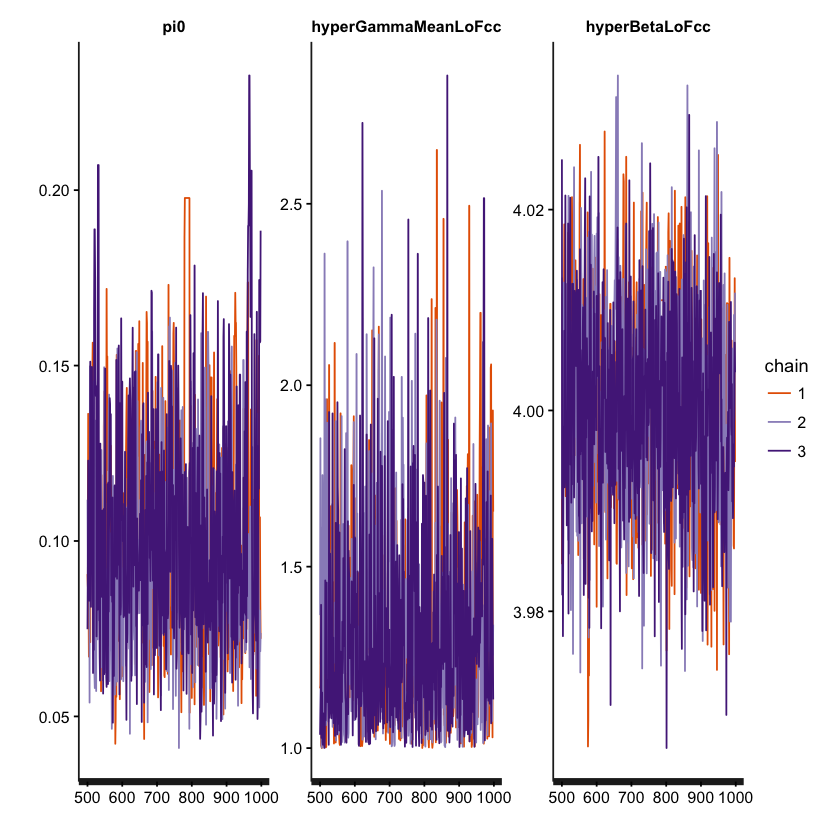

In [14]:
stan_trace(testFitSingleCC)
testFitSingleCC

### We will change q1 < q0, and add e0 into the model

In [15]:
smallNumber <- 100

sDenovoCC <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.15, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1]/smallNumber, nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])

class(sDenovoCC)
str(sDenovoCC)

sCountCC <- (sDenovoCC$sample)
str(sCountCC)

head(sCountCC)


[1] "list"

List of 2
 $ sample     : num [1:18735, 1:3] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:8] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:8] "mu" "z" "" "" ...
 num [1:18735, 1:3] 0 0 0 0 0 0 0 0 0 0 ...


0,0,0
0,0,0
0,1,8
0,0,0
0,0,0
0,0,0


In [16]:
onlyCCBinom <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;
int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.99> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;

real<lower=0,upper=1> eQMean;
real<lower=0,upper=1> eQ;

}

model {

real ps[K];

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);

eQ ~ gamma(eQMean, 1);

for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], eQ*gammaLoFcc*Ncase/(eQ*gammaLoFcc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"

In [17]:
#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]

onlyCCData <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))
library("rstan")

nSeed1 <- 12345 #233
mCC <- stan_model(model_code = onlyCCBinom)
fCC <- vb(mCC, seed = nSeed1, data = onlyCCData)
fCC

clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.01467 seconds
1000 iterations under these settings should take 14.67 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Iteration: 250 / 250 [100%]  (Adaptation)
Success! Found best value [eta = 0.1].

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -6e+04             1.000            1.000
   200   -49043.5             0.632            1.000
   300   -43083.3             0.468            0.264
   400   -49985.

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: e278621524e0f1156e24f617eff88844.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                    mean   sd 2.5%  25%  50%  75% 97.5%
pi0                 0.09 0.02 0.06 0.08 0.09 0.10  0.14
hyperGammaMeanLoFcc 3.39 0.95 2.10 2.70 3.20 3.91  5.65
hyperBetaLoFcc      3.98 0.19 3.63 3.86 3.97 4.10  4.38
gammaLoFcc          3.06 0.27 2.56 2.88 3.05 3.23  3.63
eQMean              0.54 0.25 0.08 0.35 0.54 0.75  0.95
eQ                  0.54 0.25 0.08 0.35 0.54 0.75  0.95
lp__                0.19 0.02 0.16 0.18 0.19 0.20  0.23

Approximate samples were drawn using VB(meanfield) at Thu Feb 25 10:41:43 2016.

In [18]:
nIteration = 3000
nThin = floor(nIteration/1000)
nChain = nThin
nCore = nChain
testFitSingleCC <- stan(model_code = onlyCCBinom,
                      data = onlyCCData, iter = nIteration, chains = nChain,
                        thin = nThin,
                        cores = nCore,
#                      control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFcc', 'hyperBetaLoFcc', 'eQ', 'eQMean'))


Warning message:
: There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.Warning message:
: Examine the pairs() plot to diagnose sampling problems


Inference for Stan model: e278621524e0f1156e24f617eff88844.
3 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1500.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.07    0.00 0.03      0.03      0.05      0.07
hyperGammaMeanLoFcc     14.62    0.28 8.56      1.89      7.79     13.66
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
eQ                       0.06    0.00 0.08      0.01      0.02      0.04
eQMean                   0.46    0.01 0.25      0.06      0.27      0.43
lp__                -15660.15    0.09 2.27 -15665.70 -15661.29 -15659.70
                          75%     97.5% n_eff Rhat
pi0                      0.09      0.16  1111 1.00
hyperGammaMeanLoFcc     20.34     33.88   954 1.00
hyperBetaLoFcc           4.01      4.02  1448 1.00
eQ                       0.06      0.29   532 1.01
eQMean                   0.65      0.95  1283 1.00
lp__  

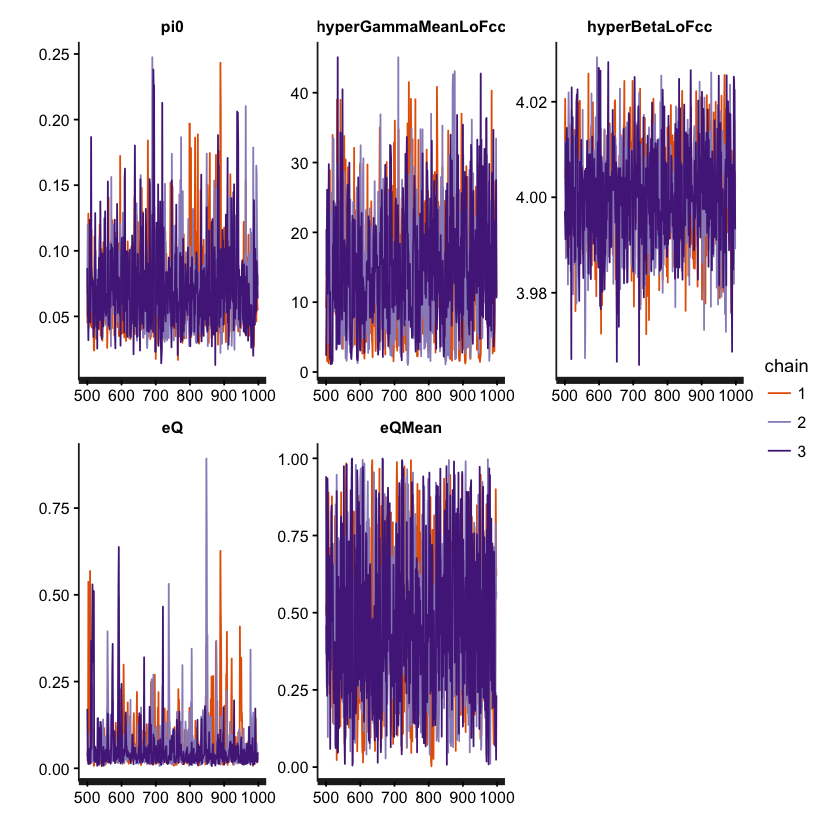

In [19]:
testFitSingleCC
stan_trace(testFitSingleCC)